In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from tslearn.metrics import cdist_dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.signal import butter, filtfilt, resample, welch

from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)


In [2]:
# set all seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# parameters
fs = 100  # Hz

In [4]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

Train set: 168 steps
Test set:  88 steps


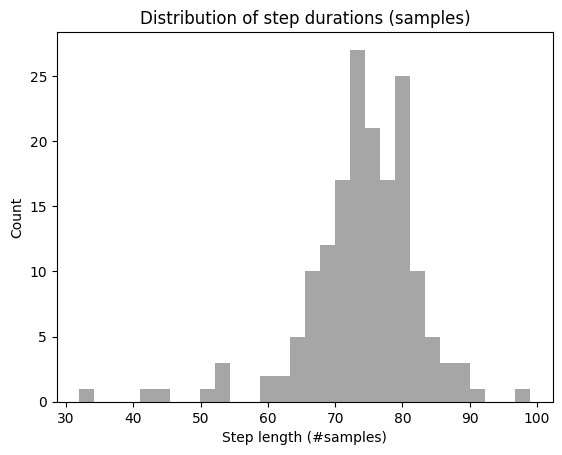

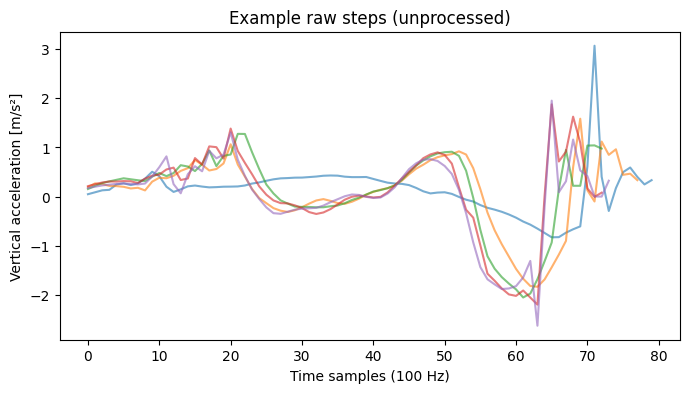

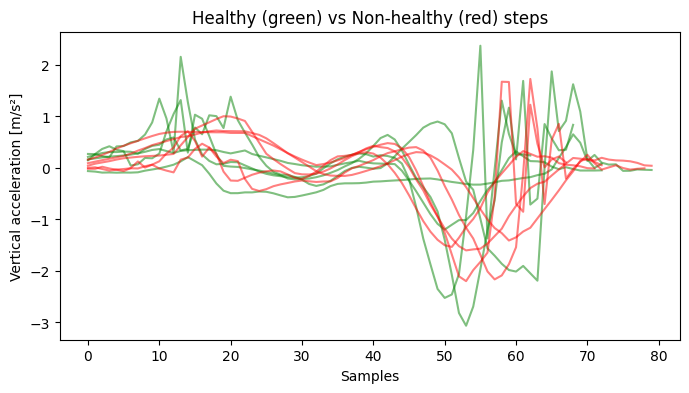

/Users/julesroyer/Code/.data-science-venv/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


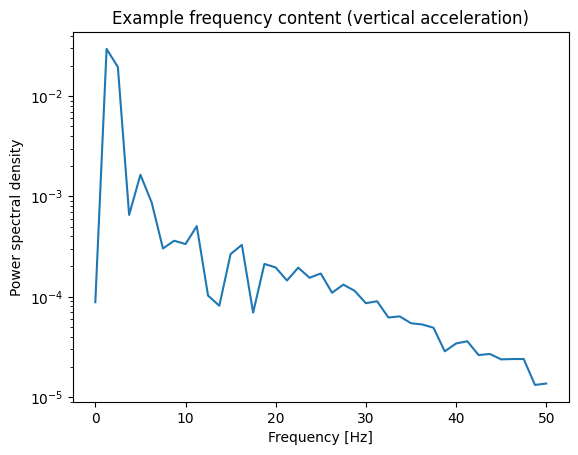

In [ ]:
# basic infos
print(f"Train set: {len(X_train)} steps")
print(f"Test set:  {len(X_test)} steps")

# distribution of step lengths
train_lengths = [len(x) for x in X_train]
plt.hist(train_lengths, bins=30, color="gray", alpha=0.7)
plt.xlabel("Step length (#samples)")
plt.ylabel("Count")
plt.title("Distribution of step durations (samples)")
plt.show()

# mean and std of step lengths
mean_length_train = int(np.mean([len(x) for x in X_train]))
std_length_train = int(np.std([len(x) for x in X_train]))
mean_length_test = int(np.mean([len(x) for x in X_test]))
std_length_test = int(np.std([len(x) for x in X_test]))
print(f"Mean length of footstep signals (train): {mean_length_train}")
print(f"Std length of footstep signals (train): {std_length_train}")
print(f"Mean length of footstep signals (test): {mean_length_test}")
print(f"Std length of footstep signals (test): {std_length_test}")


# plot some steps
plt.figure(figsize=(8, 4))
for i, x in enumerate(X_train[:5]):
    plt.plot(x, alpha=0.6)
plt.title("Example unprocessed steps")
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot healthy vs non-healthy steps
healthy_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
patho_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]

plt.figure(figsize=(8, 4))
n_steps_to_plot = 5
for x in random.sample(healthy_steps, n_steps_to_plot):
    plt.plot(x, color="green", alpha=0.5)
for x in random.sample(patho_steps, n_steps_to_plot):
    plt.plot(x, color="red", alpha=0.5)
plt.title(
    f"{n_steps_to_plot} Healthy (green) vs {n_steps_to_plot} Non-healthy (red) steps"
)
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot psd of one example step
x = X_train[0]
f, Pxx = welch(x, fs=fs)
plt.semilogy(f, Pxx)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power spectral density")
plt.title("PSD of one example step")
plt.show()

In [12]:
# processing
def lowpass_filter(x, fs=100, cutoff=15, order=4):
    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x)


def preprocess_step(x, fs=100):
    x = lowpass_filter(x, fs=fs, cutoff=15)  # denoise
    x = x - np.mean(x)  # center
    x = x / (np.std(x) + 1e-8)  # normalize
    x = resample(x, mean_length_train)  # resample to mean train length
    return x


def preprocess_dataset(X, fs=100):
    return [preprocess_step(x, fs=fs) for x in X]


# process datasets
X_train_proc = preprocess_dataset(X_train)
X_test_proc = preprocess_dataset(X_test)

print(
    f"After preprocessing, all steps have mean train length length: {len(X_train_proc[0])} samples"
)

# convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

After preprocessing, all steps have mean train length length: 74 samples


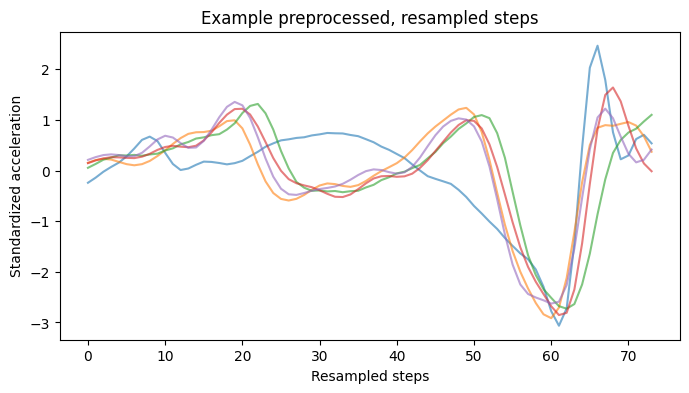

In [17]:
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(X_train_proc[i], alpha=0.6)
plt.title("Example preprocessed, resampled steps")
plt.xlabel("Resampled steps")
plt.ylabel("Standardized acceleration")
plt.show()

In [18]:
print("Computing DTW distance matrix (train–train)...")
D_train = cdist_dtw(X_train_proc)  # shape (N_train, N_train)

print("Computing DTW distance matrix (test–train)...")
D_test = cdist_dtw(X_test_proc, X_train_proc)  # shape (N_test, N_train)

Computing DTW distance matrix (train–train)...
Computing DTW distance matrix (test–train)...


In [21]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 50, 70, 100]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

best_k, best_f1 = None, 0
for k in k_values:
    fold_f1 = []
    for train_idx, val_idx in skf.split(D_train, y_train):
        D_tr = D_train[np.ix_(train_idx, train_idx)]
        D_val = D_train[np.ix_(val_idx, train_idx)]

        knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
        knn.fit(D_tr, y_train[train_idx])
        y_pred = knn.predict(D_val)
        fold_f1.append(f1_score(y_train[val_idx], y_pred))

    mean_f1 = np.mean(fold_f1)
    print(f"k={k}: mean F1={mean_f1:.3f}")
    if mean_f1 > best_f1:
        best_f1, best_k = mean_f1, k

print(f"\nOptimal k={best_k}, mean CV-F1={best_f1:.3f}")

k=1: mean F1=0.880
k=3: mean F1=0.875
k=5: mean F1=0.856
k=7: mean F1=0.884
k=9: mean F1=0.882
k=11: mean F1=0.884
k=13: mean F1=0.861
k=15: mean F1=0.820
k=20: mean F1=0.707
k=30: mean F1=0.695
k=50: mean F1=0.635
k=70: mean F1=0.566
k=100: mean F1=0.211

Optimal k=7, mean CV-F1=0.884


In [22]:
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="precomputed")
knn_final.fit(D_train, y_train)
y_pred_test = knn_final.predict(D_test)

test_f1 = f1_score(y_test, y_pred_test)
print(f"Test F-score = {test_f1:.3f}")

Test F-score = 0.523


Question 11


In [23]:
# Predict and compute per-sample correctness
y_pred_test = knn_final.predict(D_test)
errors = y_pred_test != y_test

# Get indices of misclassified steps by true class
wrong_healthy = np.where((y_test == 0) & errors)[
    0
]  # true healthy misclassified as non-healthy
wrong_patho = np.where((y_test == 1) & errors)[
    0
]  # true non-healthy misclassified as healthy

In [24]:
import random

bad_h = random.choice(wrong_healthy) if len(wrong_healthy) > 0 else None
bad_p = random.choice(wrong_patho) if len(wrong_patho) > 0 else None

print("Misclassified healthy index:", bad_h)
print("Misclassified non-healthy index:", bad_p)

Misclassified healthy index: 41
Misclassified non-healthy index: 54


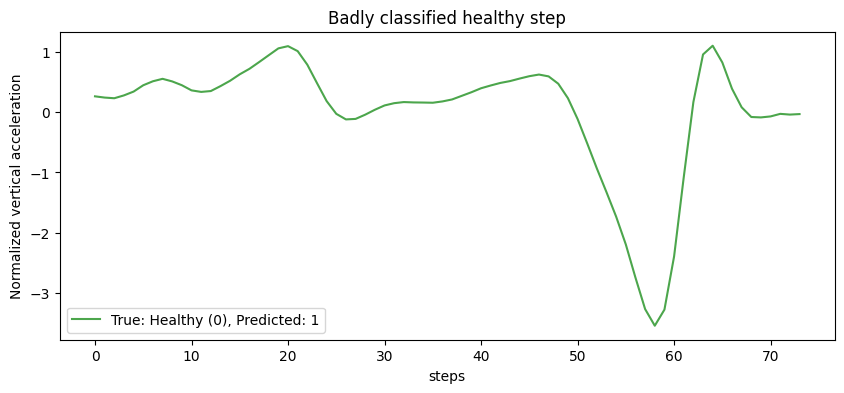

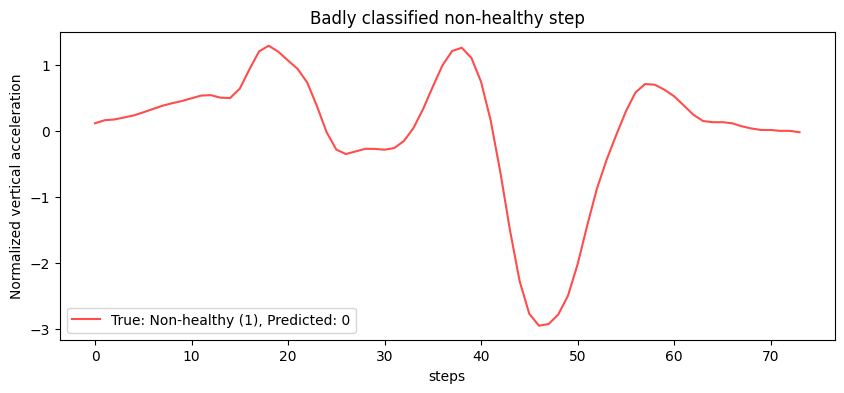

In [30]:
import matplotlib.pyplot as plt

# Misclassified healthy
plt.figure(figsize=(10, 4))
if bad_h is not None:
    plt.plot(
        X_test_proc[bad_h],
        color="green",
        alpha=0.7,
        label=f"True: Healthy (0), Predicted: {y_pred_test[bad_h]}",
    )
plt.xlabel("steps")
plt.ylabel("Normalized vertical acceleration")
plt.title("Badly classified healthy step")
plt.legend(loc="lower left")
plt.show()

# Misclassified non-healthy
plt.figure(figsize=(10, 4))
if bad_p is not None:
    plt.plot(
        X_test_proc[bad_p],
        color="red",
        alpha=0.7,
        label=f"True: Non-healthy (1), Predicted: {y_pred_test[bad_p]}",
    )
    plt.xlabel("steps")
plt.ylabel("Normalized vertical acceleration")
plt.title("Badly classified non-healthy step")
plt.legend(loc="lower left")
plt.show()